In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from numpy.random import normal
from math import ceil

In [2]:
data_1 = pd.read_csv('data_1.csv')

In [3]:
data_1

,Frequency [MHz],Weight,a: Tsky [K],b: Tres1 [K],c: Tres2 [K],d: Tmodel [K],e: T21 [K]
0,50.012207,0,0.000000,0.000000,0.000000,0.000000,0.000000
1,50.402832,0,0.000000,0.000000,0.000000,0.000000,0.000000
2,50.793457,0,0.000000,0.000000,0.000000,0.000000,0.000000
3,51.184082,1,4645.468619,-0.034440,-0.099255,0.000000,-0.099255
4,51.574707,1,4556.501107,0.071895,0.021244,0.000000,0.021244
...,...,...,...,...,...,...,...
123,98.059082,1,877.642853,-0.169377,0.006739,-0.000103,0.006636
124,98.449707,1,868.701882,-0.181803,0.018884,-0.000068,0.018816
125,98.840332,1,859.822813,-0.259145,-0.033581,-0.000044,-0.033625
126,99.230957,0,0.000000,0.000000,0.000000,0.000000,0.000000


In [4]:
#frequency
freq = data_1.iloc[:,0]

In [5]:
def func (x, y):
    #x is frequency
    #y is the array of paramaters
    #y[0]= v_0 is the center of frequency
    #y[1]= w
    #y[2] = tau
    #y[3]=A
    
    B = (4*(x-y[0])**2)*(y[1]**(-2))*(np.log((-1/y[2])*(np.log((1+np.exp(-1*y[2]))/2))))
    return -1 * y[3] * ((1-np.exp(-1*y[2]*np.exp(B)))/(1-np.exp(-1*y[2])))

def chisquare (fobs, fexp):
    return np.sum((fobs-fexp)**2)

In [14]:
#model
#ورودی تابع که شناخته شده است
params_original = [78 ,20 ,6 ,0.5] #as data
model = func (freq , params_original)

In [79]:
start_guess = [78.1 , 20.1 , 6.01 , 0.51  ] 
nstep = 30000
out_put= func(freq, start_guess)
param_length=len(start_guess)

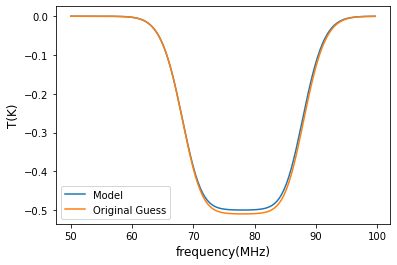

In [80]:
plt.plot(freq, model, label='Model')
plt.plot(freq, out_put, label='Original Guess') # based on first_guess
plt.xlabel('frequency(MHz)', fontsize=12)
plt.ylabel('T(K)', fontsize=12)
plt.legend()
plt.savefig('p_11')
plt.show()

In [81]:
def mcmc (max_steps, start_guess):
    
    #definig the chain
    chain = np.empty((max_steps, len(start_guess)))
    chain[0, :] = start_guess
    
    #defining the chi-square
    chisq = np.empty(max_steps)
    chisq[0] = chisquare(func(freq, start_guess), model)
    
    accepted_ratio = 0
    
    #the chain 
    for i in range(1, max_steps):
        new_param = normal(chain[i-1], 0.00008)
        new_chisq = chisquare(func(freq, new_param), model)
        
        #If chi-square gets big, we should do another step
        if new_chisq >= chisq[i-1]:
            prob = np.exp(-0.5*(new_chisq-chisq[i-1]))
            
            #print('chi-square difference is', new_chisq-chisq[i-1])
            x=np.random.rand()
            
            #print('probability is', prob)
            #print('random number is', x)
            
            if x >= prob:
                #print('higher chi-square is accepted')
                accepted_ratio = accepted_ratio + 1
                chisq[i] = new_chisq
                chain[i, :] = new_param
                
            else:
                #print('higher chi-square is not accepted')
                chisq[i] = chisq[i-1]
                chain[i, :] = chain[i-1, :]
                
        #if chi-square got small, we accept it        
        else:
            #print('lower chi-square')
            accepted_ratio = accepted_ratio + 1
            chisq[i] = new_chisq
            chain[i, :] = new_param
            
    return chain, chisq , accepted_ratio/max_steps


In [82]:
params, cs, accepted_ratio = mcmc(nstep, start_guess)

In [83]:
mcmc_result= np.empty(param_length)

for i in range(param_length):
    mcmc_result[i] = np.mean(params[:,i])
    
out_put_mcmc = func(freq, mcmc_result)
#نقطه اخر را حساب نمیکنیم. میانگین را محاسبه میکنیم

In [84]:
for i in range(param_length):
    print(f'Parameters : a_{i}= ', mcmc_result[i])

print("Chi squared of mcmc:",chisquare(func(freq, mcmc_result), model))
print("Chi squared of original guess:",chisquare(func(freq,start_guess), model))
print("acceptance_ratio for %d Steps: " %nstep + repr(accepted_ratio*100) +"%")

Parameters : a_0=  78.007462326481
Parameters : a_1=  20.01642618835949
Parameters : a_2=  6.006520891976454
Parameters : a_3=  0.4998319421677595
Chi squared of mcmc: 1.4428594888625444e-05
Chi squared of original guess: 0.007230768416060606
acceptance_ratio for 30000 Steps: 9.8%


4


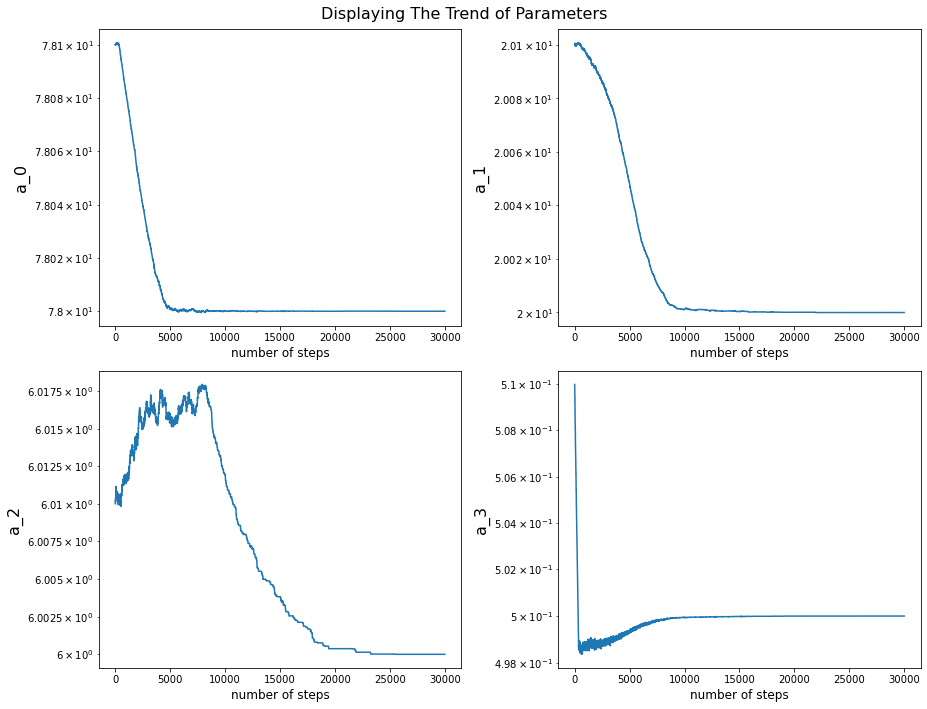

In [85]:
fig, ax_list = plt.subplots(ceil(param_length/2), 2, figsize=(13,10))
fig.suptitle('Displaying The Trend of Parameters', fontsize=16)
print(param_length)
if((param_length % 2) == 0):
    for i in range(ceil(param_length/2)):
        for j in range(2):
            #print(i)
            #print (j)
#             ax_list[i, j].plot(params[:, i*2+ j])
            ax_list[i, j].semilogy(params[:, i*2+ j])
            ax_list[i, j].set_ylabel(f'a_{i*2+ j}', fontsize=16)
            ax_list[i, j].set_xlabel('number of steps', fontsize=12)

else:
    for i in range(ceil(param_length/2)):
        for j in range(2):
            if(j == 1 and i == (ceil(param_length/2)-1)):
                break
            #print(i)
            #print (j)
#             ax_list[i, j].plot(params[:, i*2+ j])
            ax_list[i, j].semilogy(params[:, i*2+ j])
            ax_list[i, j].set_ylabel(f'a_{i*2+ j}', fontsize=16)
            ax_list[i, j].set_xlabel('number of steps', fontsize=12)
            

plt.tight_layout()
plt.savefig('p_3')
plt.show()     

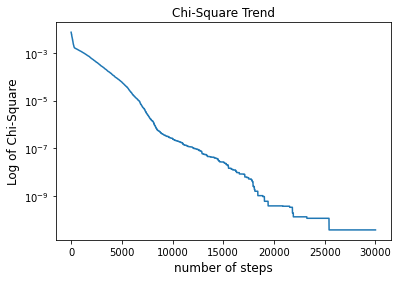

In [86]:
#Plotting the chi-square
#plt.plot(np.log(cs))
plt.semilogy(cs)
plt.xlabel('number of steps', fontsize=12)
plt.title ('Chi-Square Trend', fontsize=12)
plt.ylabel('Log of Chi-Square', fontsize=12)
#plt.ylim(top = 2E-9)
plt.savefig('p_2')
plt.show()

In [87]:
#Fourier Transform
ps = np.zeros((nstep, param_length))
for i in range(param_length):
    ps[:, i] = np.abs(np.fft.fft(params[:, i]))**2
    
freqs = np.fft.rfftfreq(nstep)
idx = np.argsort(freqs)

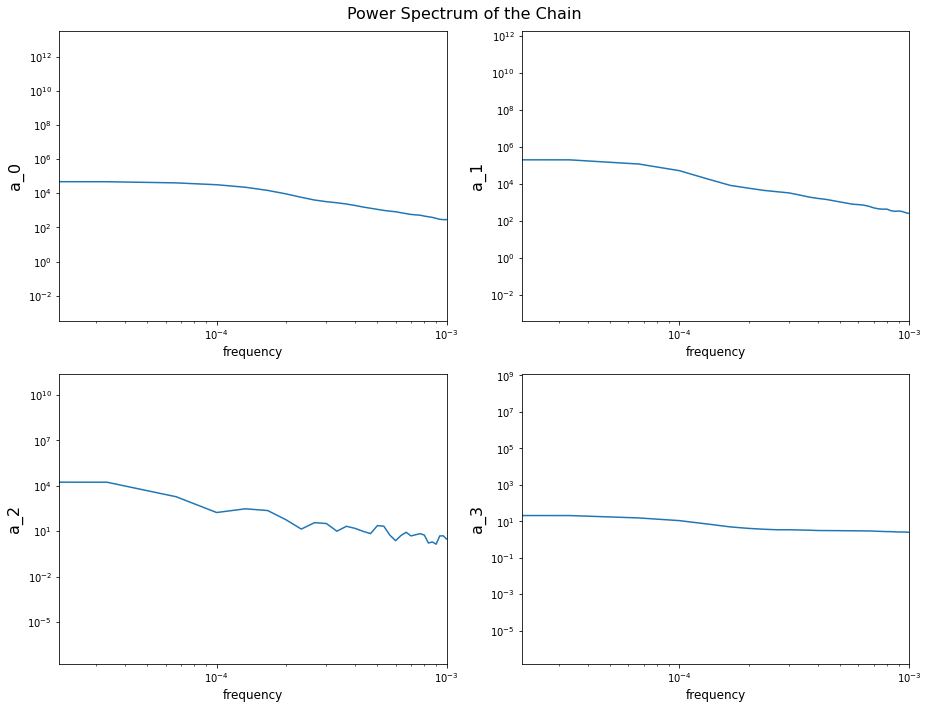

In [88]:
#Plotting the Fourier Transform
fig4, ax_list = plt.subplots(ceil(param_length/2), 2, figsize=(13,10))
fig4.suptitle('Power Spectrum of the Chain', fontsize=16)
if((param_length % 2) == 0):
    for i in range(ceil(param_length/2)):
        for j in range(2):
            ax_list[i, j].loglog(freqs[idx], ps[idx, i*2+ j])
            #plt.yscale("log")
            ax_list[i, j].set_ylabel(f'a_{i*2+ j}', fontsize=16)
            ax_list[i, j].set_xlabel('frequency', fontsize=12)
            ax_list[i, j].set_xlim(right = 1E-3)
            #ax_list[i, j].set_ylim(top = 10)

else:
    for i in range(ceil(param_length/2)):
        for j in range(2):
            if(j == 1 and i == (ceil(param_length/2)-1)):
                break
            ax_list[i, j].loglog(freqs[idx], ps[idx, i*2+ j])
            #plt.yscale("log")
            ax_list[i, j].set_ylabel(f'a_{i*2+ j}', fontsize=16)
            ax_list[i, j].set_xlabel('frequency', fontsize=12)
            #ax_list[i, j].set_ylim(0, 1E2)
            #ax_list[i, j].set_xlim(0.2, 0.5)
            
plt.tight_layout()          
plt.show()

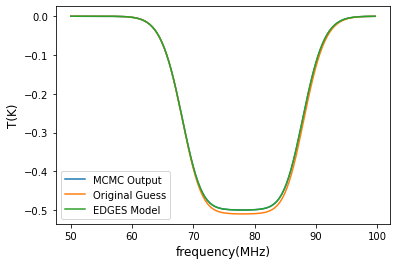

In [89]:
fig2 = plt.figure()
plt.plot(freq, out_put_mcmc, label="MCMC Output")
plt.plot(freq, out_put, label= "Original Guess")
plt.plot(freq, model, label= 'EDGES Model')
plt.legend()
plt.xlabel('frequency(MHz)', fontsize=12)
plt.ylabel('T(K)', fontsize=12)
plt.savefig('p_4')
#plt.ylim(top=-0.4)
#plt.xlim(65,90)
plt.show()